<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Binary Variational Semantic Hashing </h1>

<H3 align='center'> INF-483 Recuperación de Información/Text Mining 2018-2</H3>
<hr style="height:2px;border:none"/>


<img src="https://i.imgur.com/qhcBPAS.png" title="Title text"  width="50%" style="float: right;" />


> ** Nombre:** Francisco Mena  
> ** Rol **: 201373504-5  
> **Fecha**: 15/01
---

Encontrar/Recuperar objetos similares dada un objeto como consulta (*content-based retrieval*) utilizando *hashing* semántico para acelerar la búsqueda. La idea es asignar códigos binarios compactos (de baja dimensionalidad) a cada objeto), la propiedad semántica es para que objetos semánticamente similares generen códigos similares en el espacio de *Hamming*.


**Objetivo**: Mejorar el aprendizaje no supervisado de *hashing* semántico a través de un modelo probabilista que se adapte correctamente a la necesidad de generar códigos binarios

**Técnica**: *Variational Autoencoder* (VAE)


Utilizando el *reparameterization trick*:
* https://github.com/EderSantana/gumbel/
* https://github.com/EmilienDupont/vae-concrete

En primer lugar se cargan las librerías a utilizar.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import numpy as np
import keras,gc,nltk
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.special import expit
import seaborn as sns
import pandas as pd
nltk.download('reuters')
nltk.download('wordnet')
%matplotlib inline

from base_networks import *

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

## Load Data

### 20 Newsgroup
---

Utilizado en trabajos previos de *Hashing* de texto (http://people.csail.mit.edu/jrennie/20Newsgroups), también disponible en **sklearn**. El dataset contiene textos de usuarios asociados a temáticas de noticias etiquetados como pertenenciente a uno de 20 grupos de noticias, el detalle de los conjuntos se detalla a continuación:

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|11.314|20|
|Pruebas|7.532|20|

In [3]:
dat_n = "20News"

from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
labels = newsgroups_t.target_names

texts_t = newsgroups_t.data
y_t = newsgroups_t.target
labels_t = [labels[valor] for valor in y_t]

texts_test = newsgroups_test.data
y_test = newsgroups_test.target
labels_test = [labels[valor] for valor in y_test]

print("Datos de entrenamiento: ",y_t.shape)
print("Datos de prueba: ",y_test.shape)

Datos de entrenamiento:  (11314,)
Datos de prueba:  (7532,)


In [4]:
labels

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Anteriormente se presentan los 20 posibles grupos de las noticias, algunos ejemplos de texto se muestran a continuacion:

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







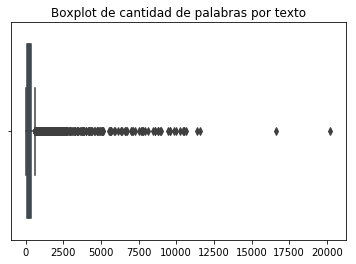

In [10]:
print(texts_t[0])
sns.boxplot(list(map(len,[texto.split(' ') for texto in texts_t])))
plt.title("Boxplot de cantidad de palabras por texto")
plt.show()

In [112]:
## specific clean on this dataset:
headers_to_save = ["Subject","Summary","Organization","Keywords"]

def clean_20news(textos):
    aux = []
    for textito in textos:
        header,texto = textito.split("\n\n",1)

        #dic = {line.split(": ")[0]:line.split(": ")[1] for line in header.split("\n") }
        dic = {}
        for line in header.split("\n"):
            try:
                a,b = line.split(": ",1)
                dic[a] = b
            except:
                continue
        to_add = ""
        for t in headers_to_save:
            try:
                to_add += dic[t] +". "
            except:
                continue
        aux.append(to_add+texto)
    return aux
texts_t = clean_20news(texts_t)
texts_test = clean_20news(texts_test)
print("Done!")

Done!


Es el dataset con los documentos más extensos en información o textos, lo que podría ser un indicador que es el más difícil ya que se deberá comprimir toda la información presente en estos textos.

### Reuters21578
---
Similar a 20NewsGroup es un datataset de textos de noticias del periodico de Reuters en 1987, citado también en el estado del arte (https://www.nltk.org/book/ch02.html) y disponible en la librería **nltk**. El detalle de los conjuntos se muestra a continuación:

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|7.769|90|
|Pruebas|3.019|90|

Los documentos pueden pertenecer a **múltiples tópicos** dentro de 90 disponibles en el dataset manualmente etiquetadas, ésto es porque un texto asociado a una noticia puede hablar de varios tópicos a la vez. 

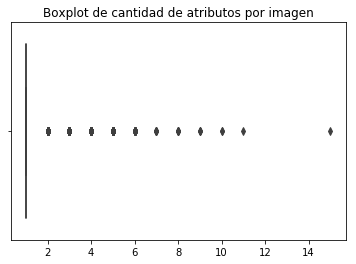

In [3]:
sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de atributos por imagen")
plt.show()

In [27]:
dat_n = "Reuters"

from nltk.corpus import reuters
documents_stat = reuters.fileids()
print(str(len(documents_stat)) + " documents")

train_docs_stat = list(filter(lambda doc: doc.startswith("train"), documents_stat))
print(str(len(train_docs_stat)) + " total training documents")
test_docs_stat = list(filter(lambda doc: doc.startswith("test"), documents_stat))
print(str(len(test_docs_stat)) + " total test documents")

texts_t = [reuters.raw(archivo) for archivo in train_docs_stat]
labels_t = [reuters.categories(archivo) for archivo in train_docs_stat]

texts_test = [reuters.raw(archivo) for archivo in test_docs_stat]
labels_test = [reuters.categories(archivo) for archivo in test_docs_stat]

labels = reuters.categories()

10788 documents
7769 total training documents
3019 total test documents


BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at the same stage last year. Again it seems
  that cocoa delivered earlier on consignment was included in the
  arrivals figures.
      Comissaria Smith said there is still some doubt as to how
  much old crop cocoa is still available as harvesting has
  practically come to an end. With total Bahia crop estimates
  around 6.4 mln bags and sales standing at almost 6.2 mln there
  are a few hundred thousand bags still in the hands of farmers,
  middlemen, exporters and processors.
      There are doubt

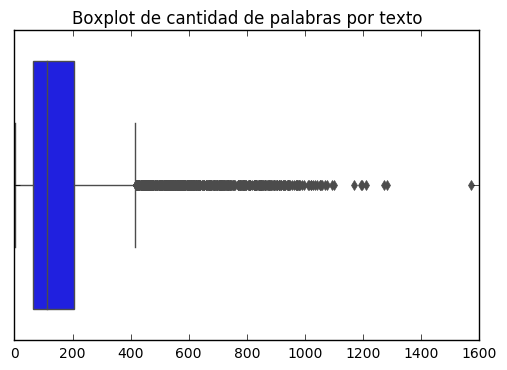

In [110]:
print(texts_t[0])

sns.boxplot(list(map(len,[texto.split(' ') for texto in texts_t])))
plt.title("Boxplot de cantidad de palabras por texto")
plt.show()

In [47]:
labels_t[:10]

[['cocoa'],
 ['acq'],
 ['money-supply'],
 ['acq'],
 ['earn'],
 ['earn'],
 ['acq', 'trade'],
 ['earn'],
 ['crude', 'nat-gas'],
 ['cocoa', 'coffee', 'sugar']]

#### top 20 labels (as VDSH)

In [28]:
from utils import get_topK_labels,set_newlabel_list,enmask_data
new_labels = get_topK_labels(labels_t+labels_test, labels, K=20)
labels = new_labels
new_labels

category with most data (earn) has = 3964, the top-K category (bop) has = 105


['earn',
 'acq',
 'money-fx',
 'grain',
 'crude',
 'trade',
 'interest',
 'ship',
 'wheat',
 'corn',
 'dlr',
 'money-supply',
 'oilseed',
 'sugar',
 'coffee',
 'gnp',
 'gold',
 'veg-oil',
 'soybean',
 'bop']

In [ ]:
labels_t = mask_label_list(new_labels, labels_t)
labels_test = mask_label_list(new_labels, labels_test)
# y si quedan datos sin clase?

mask_used_t = np.asarray(list(map(len,labels_t))) != 0
mask_used_test = np.asarray(list(map(len,labels_test))) != 0
labels_t[:10]

In [66]:
#remove data withouts tags/label
texts_t = enmask_data(texts_t, mask_used_t)
texts_test= enmask_data(texts_test, mask_used_test)

labels_t = enmask_data(labels_t, mask_used_t)
labels_test = enmask_data(labels_test, mask_used_test)
len(labels_t)

4511

El dataset anterior también es extenso en sus documentos pero no tan extremo como 20 Newsgroup.

### SearchSnipet
---
Dataset de Google search *snippets*-- pequeñas porciones de texto que le dan a usuarios una idea de lo que hay en el sitio web en el buscador de Google. Pertenecientes a 8 clases únicas (dominio). Disponibles a través de http://jwebpro.sourceforge.net/data-web-snippets.tar.gz.


|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|10.060|8|
|Pruebas|2.280|8|

In [45]:
dat_n = "Snippets"

def read_file(archivo,symb=' '):
    with open(archivo,'r') as f:
        lineas = f.readlines()
        tokens_f = [linea.strip().split(symb) for linea in lineas]
        labels = [tokens[-1] for tokens in tokens_f]
        tokens = [' '.join(tokens[:-1]) for tokens in tokens_f]
    return labels,tokens
labels_t,texts_t = read_file("Data/data-web-snippets/train.txt")
labels_test,texts_test = read_file("Data/data-web-snippets/test.txt")
print("Datos de entrenamiento: ",len(texts_t))
print("Datos de pruebas: ",len(texts_test))

Datos de entrenamiento:  10060
Datos de pruebas:  2280


In [46]:
labels = list(set(labels_t))
labels

['education-science',
 'computers',
 'culture-arts-entertainment',
 'engineering',
 'health',
 'politics-society',
 'business',
 'sports']

europa enterprise pharmaceuticals eudralex homev eudralex volume medicinal products human veterinary annex manufacture biological medicinal products human annex manufacture products human blood human plasma


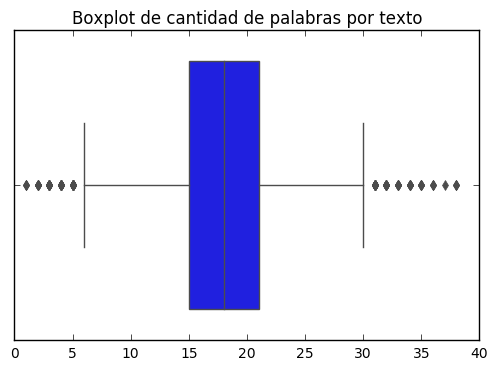

In [112]:
print(texts_t[10])

sns.boxplot(list(map(len,[texto.split(' ') for texto in texts_t])))
plt.title("Boxplot de cantidad de palabras por texto")
plt.show()

### Reuters Corpus Volume 1
---
Corpus de Reuters extendido, con los 103 tópicos originales. Disponible en trabajos previos (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html) y a través de **sklearn** (https://scikit-learn.org/0.17/datasets/rcv1.html). La representación son las *features* ya extraídas.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|23.149|103|
|Pruebas|781.265|103|

Representación de **sklearn** viene pre-procesada con la transformación logarítmica de TF-IDF.

In [2]:
from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')
X_train = rcv1_train.data
y_train = rcv1_train.target
X_test = rcv1_test.data
y_test = rcv1_test.target
labels = rcv1_train.target_names

X_train

<23149x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 1757801 stored elements in Compressed Sparse Row format>

### Validation creation

In [47]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
labels_test = np.asarray(labels_test)
texts_train,texts_val,labels_train,labels_val  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.25)

print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))

Cantidad de datos Entrenamiento:  7545
Cantidad de datos Validación:  2515
Cantidad de datos Pruebas:  2280


## Pre-process
---
Para obtener la representación de los datos, en primer lugar se normalizan con experimentar dos tipos de pre-procesamiento:

1. El primero es el siguiente (Basado en Deep Semantic Hashing)
    * Pasar letras a minúsculas
    * Eliminar extra espacios (saltos de línea por ejemplo)
    * Remover stop words
    * Borrar todo lo que no sea letras (eliminar números y puntuaciones)
    * Conservar las top $k$ palabras/*tokens* más frecuentes
2. El segundo añade lo siguiente (Basado en Semantic Hashing)
    * Se realiza un *stemming* (Snowball) -- Lemmatization
    * Remover palabras de menos de 3 largo


Para la representación vectorial se utiliza lo siguiente:
* TF-IDF: 
$$ w_f(d) \cdot \left(1 + log\left( \frac{1+n_d}{1+df_w} \right) \right)$$
* **TF (*term frequency*)**: $$ w_f(d) $$
* Binary: $$I(w_f(d) \neq 0)$$

La representación *term frequency* es la que se toma como base, puesto que resulta natural al momento de reconstruir el dato y poder utilizar la función de pérdida *cross entropy*. Ya que para la representación *tf-idf* requeriría una función de pérdida adecuada para variable continua, que podría ser *mse*.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
#analyzer = TfidfVectorizer(ngram_range=(1, 3)).build_analyzer()
tokenizer = TfidfVectorizer().build_tokenizer()
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

"""Extract features from raw input"""
def preProcess(s): #String processor
    return s.lower().strip().strip('-').strip('_')
def number_normalize(doc):
    results = []
    for token in tokenizer(doc):
        token_pro = preProcess(token)
        if len(token_pro) != 0 and not token_pro[0].isdigit():
            results.append(token_pro)
    return results
def stemmed_words(doc):
    results = []
    for token in tokenizer(doc):
        pre_pro = preProcess(token)
        #token_pro = stemmer.stem(pre_pro) #aumenta x10 el tiempo de procesamiento
        token_pro = lemmatizer.lemmatize(pre_pro) #so can explain/interpretae -- aumenta x5 el tiempo de proce
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

def get_transform_representation(mode, analizer,min_count,max_feat):
    smooth_idf_b = False
    use_idf_b = False
    binary_b = False

    if mode == 'binary':
        binary_b = True
    elif mode == 'tf':     
        pass #default is tf
    elif mode == 'tf-idf':
        use_idf_b = True
        smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    return TfidfVectorizer(stop_words='english',tokenizer=analizer,min_df=min_count, max_df=0.8, max_features=max_feat
                                ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,norm=None
                                  ,ngram_range=(1, 3)) 

min_count = 1 #default = 1
max_feat = 10000 #Best: 10000 -- Hinton (2000)


vectorizer = get_transform_representation("tf", stemmed_words,min_count,max_feat)

%time vectorizer.fit(texts_train)
vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_test)

vectorizer2 = get_transform_representation("tf-idf", stemmed_words,min_count,max_feat)

%time vectorizer2.fit(texts_train)
vectors_train2 = vectorizer2.transform(texts_train)
vectors_val2 = vectorizer2.transform(texts_val)
vectors_test2 = vectorizer2.transform(texts_test)
vectors_train.shape

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 2.47 s


/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


(7545, 10000)

En la celda anterior se calculan dos representaciones deseables de los datos, *term frequency* y *tf-idf*. A continuación se muestra cómo quedó el vocabulario.

In [49]:
token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}
idx2token

{9521: 'virginia',
 2766: 'edu',
 1937: 'culture',
 2894: 'electronic',
 4906: 'journal',
 4687: 'interdisciplinary',
 1782: 'contemporary',
 7216: 'published',
 4896: 'john',
 4314: 'hopkins',
 9360: 'university',
 8720: 'subscription',
 9522: 'virginia edu',
 1954: 'culture electronic',
 2899: 'electronic journal',
 4897: 'john hopkins',
 4315: 'hopkins university',
 4898: 'john hopkins university',
 6475: 'paint',
 4551: 'information',
 9188: 'trend',
 1202: 'cause',
 8444: 'solution',
 7412: 'recommendation',
 6478: 'painting',
 8759: 'surface',
 2128: 'decorative',
 8871: 'technique',
 3278: 'faq',
 3842: 'glossary',
 2259: 'description',
 4774: 'ipl',
 2477: 'div',
 8712: 'subject',
 933: 'browse',
 4361: 'hum',
 4712: 'internet',
 7202: 'public',
 5127: 'library',
 5207: 'literature',
 2253: 'depth',
 2137: 'definition',
 7225: 'pulp',
 3342: 'fiction',
 1283: 'character',
 9485: 'version',
 4775: 'ipl div',
 2478: 'div subject',
 8713: 'subject browse',
 4723: 'internet public'

In [50]:
#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())

X_train2 = np.asarray(vectors_train2.todense())
X_val2 = np.asarray(vectors_val2.todense())
X_test2 = np.asarray(vectors_test2.todense())

del vectors_train,vectors_val,vectors_test,vectors_train2,vectors_val2,vectors_test2
gc.collect()

X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

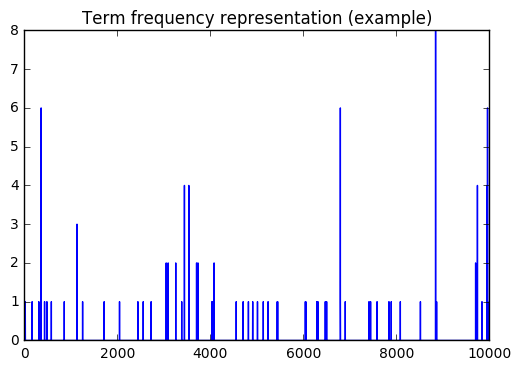

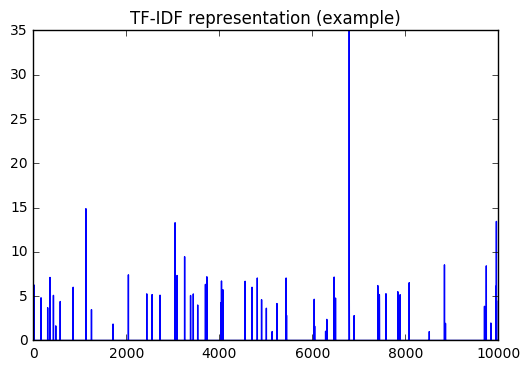

In [6]:
plt.title("Term frequency representation (example)")
plt.plot(X_train[0])
plt.show()

plt.title("TF-IDF representation (example)")
plt.plot(X_train2[0])
plt.show()

### Model Architecture
---
La arquitectura para afrontar el problema es una red clásica *Feed Forward* basado en el *baseline* de *Variational Deep Semantic Hashing* (VDSH), la cual es una arquitectura de *autoencoder* no simétrico con dos capas escondidas en el *encoder* y sin capas escondidas en el *decoder*.


> Input(|V|) -> Relu(500) -> Relu (500) -> Laten variable(32)-> Sampling -> Softmax(|V|)


Tamién se experimenta con una arquitectura de autoencoder simétrico, lo cual asimila de mejor manera lo que es una RBM (red bidireccional) como se realiza en el trabajo de *Semantic Hashing*.

La primera experimentación se realiza con 32 *bits* en la representación latente, ya que los trabajos previos han mostrado que esta cantidad de *bits* parece ser lo suficiente antes de empezar a realizar *overfitting*.

In [51]:
def REC_loss(x_true, x_pred):
    return keras.losses.categorical_crossentropy(x_true, x_pred)

beta = 1/X_train.shape[1] #0.01*X_train.sum(axis=1).mean() #tf_mean
#beta = X_train.sum(axis=-1).mean()/X_train.shape[1]
beta

0.0001

In [52]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    print("generator network:")
    generator.summary()
    
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)
    
    Recon_loss = REC_loss
    kl_loss = KL_loss(z_mean,z_log_var)
    def VAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt, loss=VAE_loss, metrics = [Recon_loss,kl_loss])
    return traditional_vae,encoder,generator

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.summary()

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_81 (Batc (None, 500)               2000      
_________________________________________________________________
dense_130 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_82 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 1000

In [53]:
anneal_rate = 0.003
min_temperature = 0.5

def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)

class My_Callback(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(tau_ann, np.max([K.get_value(tau_ann) * np.exp(- anneal_rate * epoch), min_temperature])) 
        print(tau_ann.value().eval(session=keras.backend.get_session()))
        return

def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True):
    tau = keras.backend.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3
    
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    print("generator network:")
    generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)

    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    def BVAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss])
    return binary_vae, encoder,generator
    
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.summary()

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_83 (Batc (None, 500)               2000      
_________________________________________________________________
dense_133 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_84 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 1000

### Train details
---

* 30* epochs* 
* *batch size* de 100
* optimizador Adam
* Inicializador de Glorot (para los pesos)


Desde el clásico variational lower bound of the marginal likelihood de Variational Autoencoder:

$$
\ell \geq \mathbb{E}_Q\left[\log{P(d,b)} -\log{Q(b|d)}  \right]
$$

$$
\ell \geq \mathbb{E}_Q\left[\log{P(d|b)}\right] - D_{KL}\left( Q(b|d) \mid \mid P(b)  \right)
$$

Con $P(d|b)= \prod_{w \in \vec{d}} P(w|b)^w$ una distribución multinomial, por lo que el valor esperado de la reconstrucción del dato $\vec{d}$ se puede medir con *cross entropy* y las variables latentes $b$ son binarias independies entre sí, $b_j^{(d)} \sim Q(b_j \mid \vec{d};\phi) = Bernoulli(B_j^{(d)})$

 F.O.
$$
Min \ \mathcal{L} = Min \ \sum_{\vec{d} \in D} \left( \sum_j^J D_{KL}\left( Q(b_j \mid \vec{d};\phi) \mid \mid P(b_j)\right) \right) - \left(\sum_{w \in \vec{d}} w \cdot \log P(w \mid \vec{b}^{(d)};\theta)\right)
$$

> Con $\vec{b}^{(d)} = (b_1^{(d)},b_2^{(d)},\ldots,b_K^{(d)} ) $, Las dimensionalidades son: $\vec{d} \in \mathbb{R}^{{V}}$, y representa al vector de representación de un documento, $w$ es la representación de una palabra, por ejemplo la cantidad de repeticiones en el documento, $\vec{b} \in \mathbb{R}^K$, con $|V|$  el tamaño del vocabulario o cantidad de *tokens* a utilizar, $D$ la cantidad de documentos en el dataset, $J$ la cantidad de bits a representar como variable latente.

> Utilizando el truco de reparametrización de Gumbel-softmax (caso binario), con $U \sim$ Uniform$(0,1)$, se tiene:
$$b_j^{(d)} = \sigma \left(\left( \log{ \frac{B_j^{(d)}}{1-B_j^{(d)}}} + \log{\frac{U}{1-U}} \right)/\lambda \right) $$

>> En la implementación se aprende $logits_b = \log{\frac{B_j^{(d)}}{1-B_j^{(d)}}}$:
$$b_j^{(d)} = \sigma \left(\left( logits_b+ \log{\frac{U}{1-U}} \right)/\lambda \right) $$

> Con el *prior* de $P(b_j)=0.5$ para todo *bit* $j$ la divergencia KL queda con una forma cerrada igual a:
\begin{align}
\sum_j^K D_{KL}\left( Q(b_j \mid \vec{d};\phi) \mid \mid P(b_j)\right) &= \sum_j^J \mathbb{E}_{Q(b_j)}[Q(b_j \mid \vec{d};\phi)] - \mathbb{E}_{Q(b_j)}[P(b_j)]  \\ 
&= K\cdot \log{2} + \sum_j^J B_j^{(d)} \cdot \log{B_j^{(d)}} + (1-B_j^{(d)})\cdot \log{(1-B_j^{(d)} )}
\end{align}

>> En la implementación se aprende $logits_b = \log{\frac{B_j^{(d)}}{1-B_j^{(d)}}}$:
$$ = K\cdot \log{2} + \sum_j^J B_j^{(d)} \cdot logits_b + \log{(1-B_j^{(d)} )} $$

* $Q(b_j \mid \vec{d};\phi)$ asemeja lo que es el encoder, a través de ser una función que obtiene los parámetros de la distribución de la variable latente $b_j$ dependiente del documento, $B_j^{(d)}$
* $P(w \mid \vec{b}^{(d)};\theta)$ asemeja lo que es el decoder, a través de ser una función que obtiene la distribución de probabilidad sobre las palabras $w$ dependiendo de la variable latente muestreada $\vec{b}^{(d)}$.
* En base a lo comentado en Concrete distribution y para evitar el tener que experimentar con la tasa/nivel de setear la temperatura $\lambda$ se setea a  2/3 como se comenta que es una buena forma de inicializar.


Primeras experimentaciones leves:
* **Añadir** *Batch Normalization* ayuda a estabilizar el entrenamiento
* **Max features** (*top k tokens*)  en características/representación fuciona mucho mejor que **min count**. Reduce el número de parámetros del modelo y también el *overfitting*
* Para representación *Term Frecuency* como entrada al modelo es necesario normalizar con transformación logarítimica: $\log{(tf+1)}$, mucho más estable el entrenamiento

In [8]:
from utils import  compare_hist_train

batch_size = 100
epochs = 30

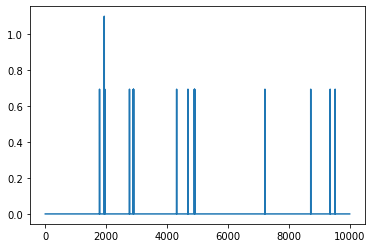

In [54]:
##representacion soft para TF ---mucho mejor!
X_train_input = np.log(X_train+1) 
X_val_input = np.log(X_val+1) 
X_test_input = np.log(X_test+1) 
plt.plot(X_train_input[0])
plt.show()

#soft para tf-idf
X_train_input2 = np.log(X_train2+1) 
X_val_input2 = np.log(X_val2+1) 
X_test_input2 = np.log(X_test2+1) 

In [29]:
from utils_VDSH import Load_Dataset
#https://github.com/unsuthee/VariationalDeepSemanticHashing
## load data used for VDSH - for sake comparison

#filename = 'Data/ng20.tfidf.mat'
filename = 'Data/reuters.tfidf.mat'
data = Load_Dataset(filename)

X_train_input = data.train
X_train = X_train_input #(X_train_input >0)*1 #binary..
X_val_input = data.cv
X_val = X_val_input #(X_val_input >0)*1 #binary..
X_test_input = data.test
X_test = X_test_input #(X_test_input >0)*1 #binary..

beta = 1/X_train.shape[1]
#beta = 1/X_train.sum(axis=-1).mean()
#beta = X_train.sum(axis=-1).mean()/X_train.shape[1]

if "ng20" in filename:
    labels_train = np.asarray([labels[value.argmax(axis=-1)] for value in data.gnd_train])
    labels_val = np.asarray([labels[value.argmax(axis=-1)] for value in data.gnd_cv])
    labels_test = np.asarray([labels[value.argmax(axis=-1)] for value in data.gnd_test])
elif "reuters" in filename:
    labels = np.asarray(labels)
    labels_train = np.asarray([labels[value.astype(bool)] for value in data.gnd_train])
    labels_val = np.asarray([labels[value.astype(bool)] for value in data.gnd_cv])
    labels_test = np.asarray([labels[value.astype(bool)] for value in data.gnd_test])

labels_train

array([array(['trade'], dtype='<U12'), array(['veg-oil'], dtype='<U12'),
       array(['earn'], dtype='<U12'), ..., array(['gnp'], dtype='<U12'),
       array(['trade'], dtype='<U12'), array(['earn'], dtype='<U12')],
      dtype=object)

In [55]:
hist1 = traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 7545 samples, validate on 2515 samples
Epoch 1/30
7545/7545 [==============================] - 8s 1ms/step - loss: 172.8831 - REC_loss: 172.1156 - KL: 7674.8712 - val_loss: 132.8497 - val_REC_loss: 132.6038 - val_KL: 2459.3943
Epoch 2/30
7545/7545 [==============================] - 2s 226us/step - loss: 135.1031 - REC_loss: 135.0126 - KL: 905.1608 - val_loss: 109.9554 - val_REC_loss: 109.8396 - val_KL: 1158.5335
Epoch 3/30
7545/7545 [==============================] - 2s 229us/step - loss: 113.7925 - REC_loss: 113.6607 - KL: 1317.5669 - val_loss: 101.1497 - val_REC_loss: 101.0214 - val_KL: 1282.5151
Epoch 4/30
7545/7545 [==============================] - 2s 228us/step - loss: 101.3379 - REC_loss: 101.1737 - KL: 1642.1133 - val_loss: 96.8976 - val_REC_loss: 96.7545 - val_KL: 1430.6666
Epoch 5/30
7545/7545 [==============================] - 2s 228us/step - loss: 93.6955 - REC_loss: 93.5062 - KL: 1893.5437 - val_loss: 94.1662 - val_REC_loss: 94.0085 - val_KL: 1576.8632
Epoch 6/30


In [56]:
hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 7545 samples, validate on 2515 samples
Epoch 1/30
7545/7545 [==============================] - 8s 1ms/step - loss: 177.2481 - REC_loss: 177.2470 - KL: 11.4329 - val_loss: 147.4373 - val_REC_loss: 147.4355 - val_KL: 18.7196
Epoch 2/30
7545/7545 [==============================] - 2s 217us/step - loss: 165.3928 - REC_loss: 165.3910 - KL: 18.0246 - val_loss: 143.0082 - val_REC_loss: 143.0063 - val_KL: 18.7918
Epoch 3/30
7545/7545 [==============================] - 2s 220us/step - loss: 162.5949 - REC_loss: 162.5932 - KL: 17.2910 - val_loss: 141.4360 - val_REC_loss: 141.4342 - val_KL: 18.1292
Epoch 4/30
7545/7545 [==============================] - 2s 218us/step - loss: 160.6774 - REC_loss: 160.6757 - KL: 17.7531 - val_loss: 139.8060 - val_REC_loss: 139.8042 - val_KL: 18.2430
Epoch 5/30
7545/7545 [==============================] - 2s 218us/step - loss: 158.6354 - REC_loss: 158.6336 - KL: 18.4390 - val_loss: 138.0535 - val_REC_loss: 138.0517 - val_KL: 18.3232
Epoch 6/30
7545/7545 [==

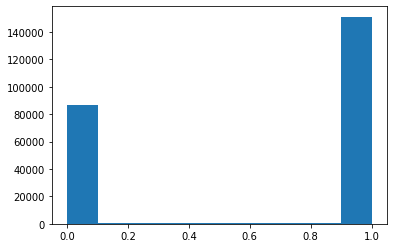

array([[9.99999969e-01, 1.00000000e+00, 1.00000000e+00, ...,
        9.99994144e-01, 1.00000000e+00, 1.36406776e-02],
       [9.99999930e-01, 2.47333044e-02, 9.77011932e-01, ...,
        9.99997888e-01, 9.99981454e-01, 9.99999885e-01],
       [1.13914288e-04, 1.00000000e+00, 1.00000000e+00, ...,
        9.99999785e-01, 3.88144661e-01, 9.99999453e-01],
       ...,
       [9.99991301e-01, 1.00000000e+00, 9.99999976e-01, ...,
        1.00000000e+00, 9.99999951e-01, 1.00000000e+00],
       [9.99991590e-01, 1.00000000e+00, 1.25795562e-11, ...,
        9.99999902e-01, 9.99999998e-01, 9.97886124e-01],
       [8.97649441e-04, 1.00000000e+00, 1.00000000e+00, ...,
        9.99999983e-01, 1.00000000e+00, 6.59851587e-01]])

In [57]:
def samp_gumb(logits):
    eps = K.epsilon()
    U = np.random.uniform(0, 1, logits.shape)
    b = logits + np.log(U + eps)- np.log(1-U + eps)
    return expit(b/0.67) #maybe lower

X_train_Bcode_samp = samp_gumb(encoder_Bvae.predict(X_train_input))

plt.hist(X_train_Bcode_samp.flatten())
plt.show()
X_train_Bcode_samp

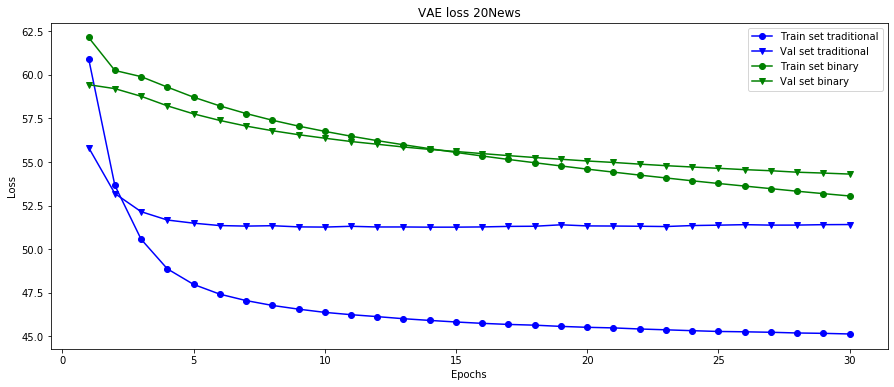

In [11]:
compare_hist_train(hist1,hist2, dat_n)

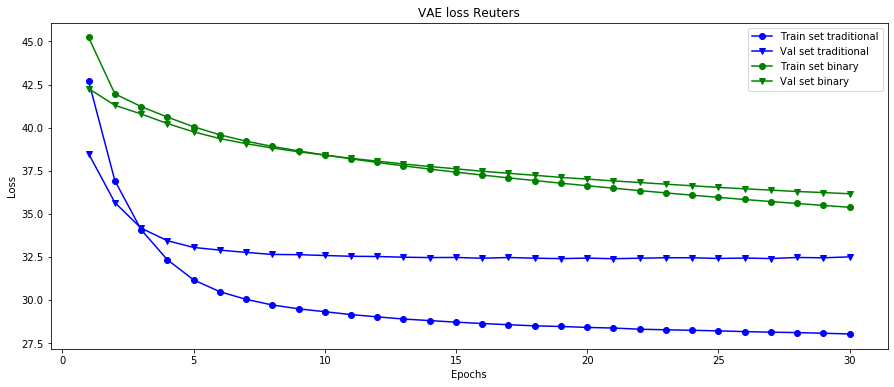

In [35]:
compare_hist_train(hist1,hist2, dat_n)

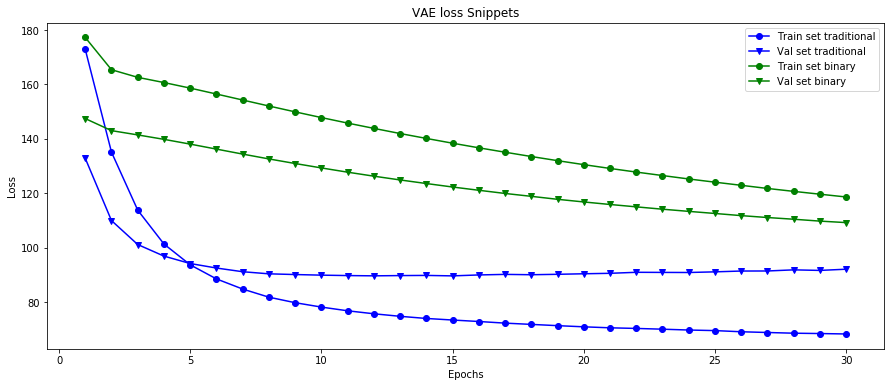

In [58]:
compare_hist_train(hist1,hist2, dat_n)

### Another intrinsic measure: *Classification*


In [12]:
#function to define and train model
from sklearn.metrics import jaccard_score
from utils import define_fit, MedianHashing

results = []
results_B = []

In [59]:
#codify input data (binarize -- or aprox)
X_train_Bcode = expit(encoder_Bvae.predict(X_train_input))
X_val_Bcode = expit(encoder_Bvae.predict(X_val_input))
#X_train_Bcode = encoder_Bvae.predict(X_train_input)
#X_val_Bcode = encoder_Bvae.predict(X_val_input)

X_train_Tcode = encoder_Tvae.predict(X_train_input)
X_val_Tcode = encoder_Tvae.predict(X_val_input)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
C_val = codify_labels(labels_val)
C_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

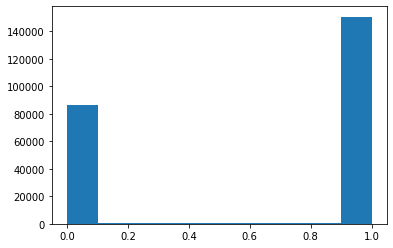

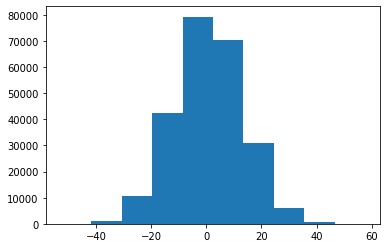

In [60]:
plt.hist(X_train_Bcode.flatten())
plt.show()

plt.hist(X_train_Tcode.flatten())
plt.show()

In [61]:
aux = [dat_n]
multi_label = "Reuters" in aux

model1 = define_fit(multi_label,X_train_Bcode,C_train)
model2 = define_fit(multi_label,X_train_Tcode,C_train)
model3 = define_fit(multi_label,X_train_input,C_train)

if not multi_label:
    aux.append(model3.evaluate(X_train_input,C_train,verbose=0)[1])
    aux.append(model3.evaluate(X_val_input,C_val,verbose=0)[1])

    aux.append(model2.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model3.predict(X_train_input)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model3.predict(X_val_input)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [62]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Raw Input (train-val): %f - %f"%(valores[1],valores[2]))
    print("Traditional VAE (train-val): %f - %f"%(valores[3],valores[4]))
    print("Binary VAE (train-val): %f - %f"%(valores[5],valores[6]))


Accuracy on dataset:  20News
Raw Input (train-val): 0.999546 - 0.841560
Traditional VAE (train-val): 0.976489 - 0.730297
Binary VAE (train-val): 0.807916 - 0.704118

Accuracy on dataset:  Reuters
Raw Input (train-val): 0.992804 - 0.833466
Traditional VAE (train-val): 0.915449 - 0.784810
Binary VAE (train-val): 0.751566 - 0.707372

Accuracy on dataset:  Snippets
Raw Input (train-val): 0.999470 - 0.953877
Traditional VAE (train-val): 0.968191 - 0.821471
Binary VAE (train-val): 0.866269 - 0.835388


In [63]:
#Transform to binary
median= MedianHashing()
median.fit(X_train_Tcode)

X_train_Tcode_B = median.transform(X_train_Tcode)
X_val_Tcode_B = median.transform(X_val_Tcode)

X_train_Bcode_B = (X_train_Bcode>0.5)*1
X_val_Bcode_B = (X_val_Bcode>0.5)*1

X_train_Tcode_B

array([[1, 1, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [64]:
aux = [dat_n]
multi_label = "Reuters" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [65]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  20News
Traditional VAE (train-val): 0.694808 - 0.619307
Binary VAE (train-val): 0.811819 - 0.691301

Accuracy on dataset:  Reuters
Traditional VAE (train-val): 0.627993 - 0.605150
Binary VAE (train-val): 0.743373 - 0.693847

Accuracy on dataset:  Snippets
Traditional VAE (train-val): 0.705103 - 0.697416
Binary VAE (train-val): 0.858847 - 0.824652


In [123]:
#plot..
from sklearn.manifold import TSNE
n = 3000 #data to train
model = TSNE(n_components=2, metric='hamming', init= "random") #init could be pca, hamming
Tcode_plot =  model.fit_transform(X_train_Tcode[:n])

model = TSNE(n_components=2, metric='hamming', init= "random") #init could be pca, hamming
Bcode_plot =  model.fit_transform(X_train_Bcode[:n])

20 Newsgroup


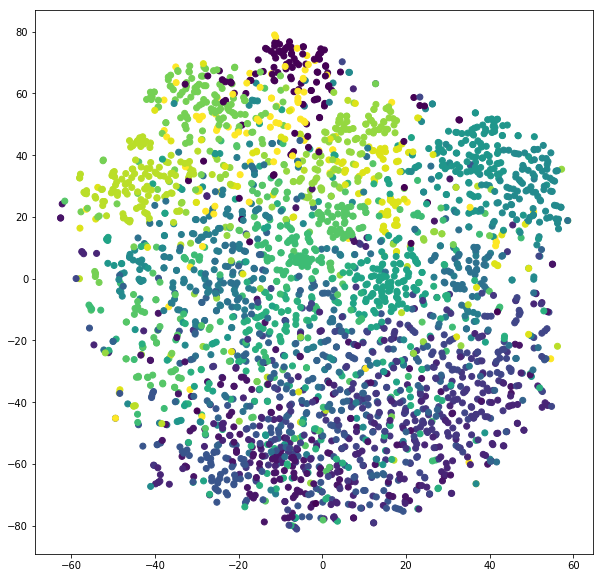

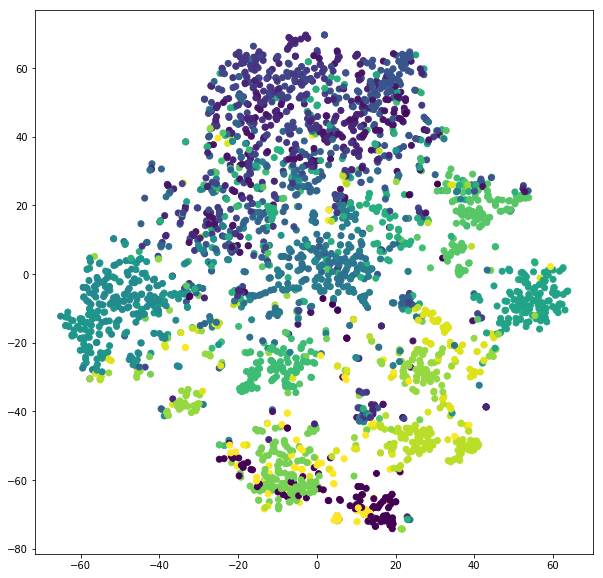

In [41]:
print("20 Newsgroup")
plt.figure(figsize=(10,10))
plt.scatter(Tcode_plot[:,0],Tcode_plot[:,1],c=C_train[:n].argmax(axis=1))
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(Bcode_plot[:,0],Bcode_plot[:,1],c=C_train[:n].argmax(axis=1))
plt.show()

Reuters


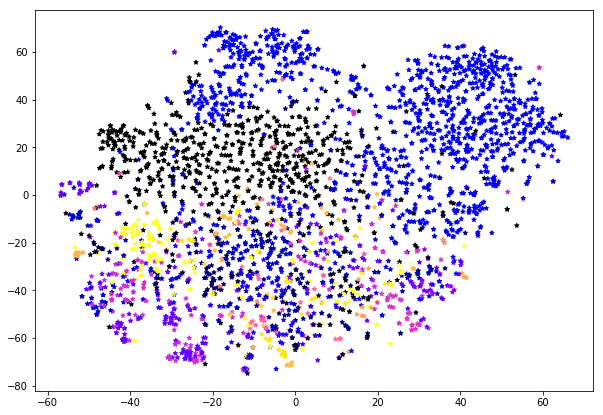

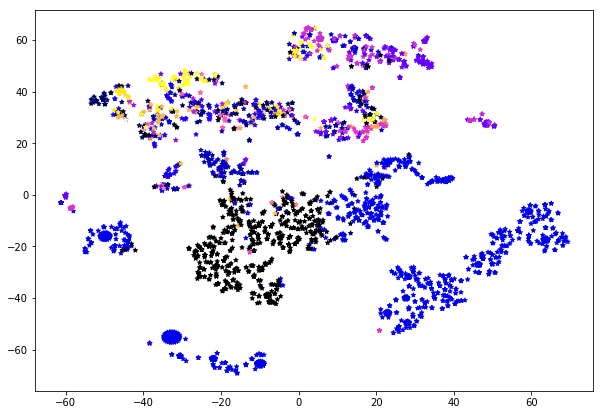

In [106]:
print("Reuters")
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])])
plt.figure(figsize=(10,7))
plt.scatter(Tcode_plot[:,0],Tcode_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) # o x
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(Bcode_plot[:,0],Bcode_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20)
plt.show()

Snippets


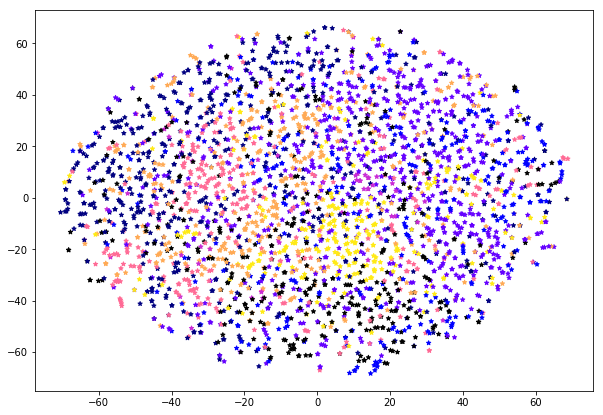

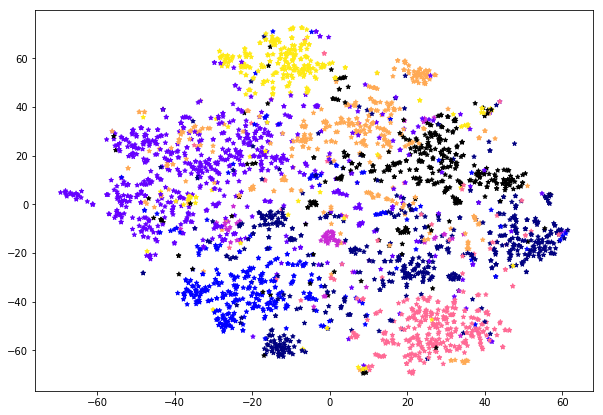

In [124]:
print("Snippets")
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])])
plt.figure(figsize=(10,7))
plt.scatter(Tcode_plot[:,0],Tcode_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) # o x
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(Bcode_plot[:,0],Bcode_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20)
plt.show()

A través de las curvas de entrenamiento se puede ver que el VAE tradicional obtiene mejores resultados que el binario respecto a la reconstrucción de los datos, lo cual resulta bastante lógico ya que tiene valores más libres en donde pueden vivir las variables (dominio de variable latente: los reales) *vs* el binario que está mucho más restringido (dominio de variable latente: entre 0 y 1). Otra cosa a nombrar es que el modelo con variables latentes binarias reduce el *overfitting* drásticamente, disminuyendo ambas curvas en la misma proporción.

### Results
---
Para evaluar los resultados y poder comparar es necesario realizar el proceso de evaluación en un sistema de recuperación de información. Ésto es recuperar objetos similares a los objetos de una consulta/*query*. Como *baseline* para comparar se utiliza el modelo presentado en *Variational Deep Semantic Hashing* (VDSH).

#### Proceso de evaluación (*content-based retrieval*)
> *Query*: **Documento**

1. Calcular código hashing/binario de cada dato/documento
    * Para *VAE* tradicional se utiliza la mediana de cada componente como *treshold*
    * Para *VAE* binario se utiliza el *treshold* de 0.5 en la probabilidad
2. Recuperar documentos basado en *match* perfecto, *top K* o *ball search* de distancia *hamming* de un documento consulta.
    * En el mismo conjunto/*set*
    * Con *query* recupero sobre *database*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.
    * Documento relevante a otro o no -> Si comparten al menos una clase.
    
|$b_1$|$b_2$|$b_3$|$b_4$|
|---|---|---|---|
||..|..||
|1|0|1|0| 
|1|0|1|1| 
|1|0|0|0| 
|1|0|0|1|
||..|..||

In [18]:
from utils import MedianHashing, get_similar, measure_metrics

In [91]:
#load vae, encoder and generator
encode_train = encoder_Tvae.predict(X_train_input)
encode_val = encoder_Tvae.predict(X_val_input)

#para VAE tradicional
median= MedianHashing()
median.fit(encode_train)

train_hash = median.transform(encode_train)
val_hash = median.transform(encode_val)
train_hash

array([[0, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 1]])

In [92]:
encode_train = encoder_Bvae.predict(X_train_input) #logits
encode_val = encoder_Bvae.predict(X_val_input)

#para Binary VAE
probas_train = expit(encode_train)
probas_val = expit(encode_val)

train_hash = (probas_train > 0.5)*1
val_hash = (probas_val > 0.5)*1
train_hash

array([[0, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 0]])

In [14]:
val_similares_train =  get_similar(val_hash,train_hash,tipo="EM")
val_similares_train[:2]

[array([   0, 7336, 7337, ..., 3672, 3673, 3666]),
 array([   0, 7336, 7337, ..., 3672, 3673, 3666])]

En algunos casos cuando se busca con un *match* exacto no se encuentra ningún otro dato que se le asigne la misma dirección, es por ésto que se acude a otras técnicas para buscar objetos similares.

In [93]:
val_similares_train =  get_similar(val_hash,train_hash,tipo="topK",K=100)
val_similares_train[:2]

[array([2862,  379, 1129, 2895, 6263, 4418, 3399, 4822, 7106, 6162, 4681,
        1146,  357, 7387, 1108, 5062,  634,  396, 6326, 3288, 4295, 1037,
        2568, 3592, 5946,  567, 1647, 2293, 2042, 4905, 4994, 1619, 4637,
        2755, 1507, 7104, 1454, 1776, 7071, 6910, 2733, 7041, 1178, 6097,
        6814, 6451, 6128, 5805, 6167, 7079, 6704, 6636, 3024, 6321, 2353,
        1384, 1608, 1351, 2124,  922, 5378, 1797,  606, 4583, 4223, 5687,
        4913, 5697, 5126, 5709, 5354,  900, 4775, 5319, 3188, 7235, 2890,
        5396, 3297, 4627,  294, 1910, 3279, 5356, 3067, 1334, 2256, 3241,
        1762, 2437, 5084, 6471, 5177, 6650, 5469, 6802, 5807, 4068, 6969,
        2587]),
 array([2836, 7019,    3, 3152, 5656, 2983, 6109, 1362, 6912,  624, 1873,
        4811, 1675, 4782, 7151, 6469, 1274, 4680, 1034, 7198, 2787, 5835,
        4373, 2341,  757, 2508, 1728, 7279, 6946, 4845, 6335, 5164, 5168,
         330, 1545, 3723,  437, 6835, 4804,   31, 4635, 3330, 5019, 6166,
        5559, 5465, 64

In [94]:
precision,recall = measure_metrics(labels, val_similares_train,labels_query=labels_val, labels_source=labels_train)
print("Precision (query: validation, source: validation) ",precision)
print("Recall    (query: validation, source: validation) ",recall)

Precision (query: validation, source: validation)  0.5469980119284307
Recall    (query: validation, source: validation)  0.05252803409529928


### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [19]:
def evaluate_hashing(encoder,train,val,labels_train, labels_val, traditional=True,tipo="topK"):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        val_train = median.transform(encode_train)
        val_hash = median.transform(encode_val)
    else: #para Binary VAE
        probas_train = expit(encode_train)
        probas_val = expit(encode_val)
        val_train = (probas_train > 0.5)*1
        val_hash = (probas_val > 0.5)*1

    val_similares_train =  get_similar(val_hash, val_train, tipo=tipo,K=100) 
    return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)

In [67]:
sin_lemma_traditional = {}
sin_lemma_binary = {}
    
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True)

sin_lemma_traditional["precision"] = [p1, p2] 
sin_lemma_traditional["recall"] = [r1, r2]

                    
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False)

sin_lemma_binary["precision"] = [p1, p2] 
sin_lemma_binary["recall"] = [r1, r2]
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_23 (Batc (None, 500)               2000      
_________________________________________________________________
dense_35 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_24 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10000)             330000    
Total params: 330,000


In [231]:
con_lemma_traditional = {}
con_lemma_binary = {}
    
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True)

con_lemma_traditional["precision"] = [p1, p2] 
con_lemma_traditional["recall"] = [r1, r2]

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False)

con_lemma_binary["precision"] = [p1, p2] 
con_lemma_binary["recall"] = [r1, r2]
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       (None, 10000)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_73 (Batc (None, 500)               2000      
_________________________________________________________________
dense_122 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_74 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

### Resultados en 20newsgroup
Experimentación variando el tipo de pre-procesamiento y la arquitectura de la red.

In [106]:
print("Resultados de Precision en validación")

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_traditional["precision"]
t["Con Lemma"] = con_lemma_traditional["precision"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_binary["precision"]
t["Con Lemma"] = con_lemma_binary["precision"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base  0.2798540370120401  0.2841565174544985
Simetrico 0.22855275983589507 0.27704046473929445

*** VAE Binary***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base 0.27538017145651994 0.31629122615336525
Simetrico   0.339728140364405   0.352853383606297


In [107]:
print("Resultados de Recall en validación")

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_traditional["recall"]
t["Con Lemma"] = con_lemma_traditional["recall"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_binary["recall"]
t["Con Lemma"] = con_lemma_binary["recall"]
print("\n*** VAE Binary***")
print(t)

Resultados de Recall en validación

*** VAE Traditional***
               Sin Lemma          Con Lemma     
--------- ------------------- ------------------
     Base 0.19157503942601106 0.1935634800277119
Simetrico  0.1567055109236688 0.1890441069169437

*** VAE Binary***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base  0.1867768042416021 0.21653550976898298
Simetrico 0.23209726149925983 0.24124950620939722


En base a la experimentación anterior se encuentra con que aplicar *Lemmatization* a los *tokens* conlleva una mejora en ambas métricas (*precision* y *recall*), además de que utilizar una arquitectura simétrica (a pesar del incremento considerable de parámetros) conlleva una gran mejora en el *VAE* Binario, mientras que la arquitectura base (no simétrica) es mejor para el *VAE* tradicional.

### Experimentando con *TF* vs *TF-IDF*

In [13]:
traditional_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}
binary_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}

In [43]:
dataset = "snippets"
#TF
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True)
traditional_dat[dataset]["p"].append(p_t) 
traditional_dat[dataset]["r"].append(r_t) 

#IDF
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input2, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input2,X_val_input2,labels_train,labels_val,traditional=True)
traditional_dat[dataset]["p"].append(p_t) 
traditional_dat[dataset]["r"].append(r_t) 

#TF
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False)
binary_dat[dataset]["p"].append(p_b) 
binary_dat[dataset]["r"].append(r_b) 

#IDF
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input2, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input2,X_val_input2,labels_train,labels_val,traditional=False)
binary_dat[dataset]["p"].append(p_b) 
binary_dat[dataset]["r"].append(r_b)

print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_37 (Batc (None, 500)               2000      
_________________________________________________________________
dense_52 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_38 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

In [44]:
print("Resultados de Precision en validación")
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = traditional_dat["20news"]["p"]
t["Reuters"] = traditional_dat["reuters"]["p"]
t["Snippets"] = traditional_dat["snippets"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = binary_dat["20news"]["p"]
t["Reuters"] = binary_dat["reuters"]["p"]
t["Snippets"] = binary_dat["snippets"]["p"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
             20News            Reuters            Snippets     
------ ------------------ ------------------ ------------------
    TF 0.2688639666370281 0.4987653165728302 0.3486394762736693
TF-IDF 0.2852241038879395 0.5083412613006016 0.3340843825933263

*** VAE Binary***
              20News            Reuters             Snippets     
------ ------------------- ------------------ -------------------
    TF 0.35401737416583284 0.5997962122511791  0.4200052211980623
TF-IDF  0.3618618136115463  0.599744225580561 0.41140630961704383


In [45]:
print("Resultados de Recall en validación")
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = traditional_dat["20news"]["r"]
t["Reuters"] = traditional_dat["reuters"]["r"]
t["Snippets"] = traditional_dat["snippets"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = binary_dat["20news"]["r"]
t["Reuters"] = binary_dat["reuters"]["r"]
t["Snippets"] = binary_dat["snippets"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Recall en validación

*** VAE Traditional***
              20News             Reuters             Snippets     
------ ------------------- ------------------- -------------------
    TF 0.18454084740966342 0.18395508938895405 0.09803543536505138
TF-IDF 0.19430150271819863 0.18221513247670762 0.09385609805437488

*** VAE Binary***
              20News             Reuters             Snippets     
------ ------------------- ------------------- -------------------
    TF   0.241946459609219 0.23288717284653163 0.11986004136790665
TF-IDF 0.24730287141004545 0.22389574207186788 0.11696040080518362


Se puede observar que las variaciones respecto a la representación resultan en cambios bastante leves, donde en algunos casos es mejor *TF* mientras que en otros es mejor *TF-IDF*. Respecto a los datasets se puede ver que los mejores resultados se encuentran en el dataset de **Reuters**, posiblemente gracias a que su estructura de que un texto puede hablar de varios temas a la vez y no de uno solo, mientras que el peor en *precision* se encuentra en **20Newsgroup**, debido a que los textos, a pesar de pertenecer a diferentes clases, al parecer hablan de temas similares entre sí lo cual resulta que el modelo le cueste proyectar los documentos a una única región de direcciones de memorias que correspondan a una clase, ya que posiblemente los patrones entre algunas clases resultan similares entre sí. Mientras que el peor en *recall* se obtiene en el dataset de **Snippets**, posiblemente por falta de generalización en ese conjunto y que los textos de una cierta clase/dominio sea muy general por lo que los textos dentro de cada dominio podrían tener características muy distintas entre sí, lo cual hace difícil encontrar patrones similares que hagan proyectarlos a todos los de una misma clase en regiones cercanas.
### Experimentando variando el #Bits

In [20]:
traditional_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}
binary_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}

In [66]:
Nbits = np.asarray([4,8,16,32,64])
dataset = dat_n.lower()
print(dataset)

for Nbit in Nbits:
    traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0)
    traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    
    binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=2)
    binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 

snippets
pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_85 (Batc (None, 500)               2000      
_________________________________________________________________
dense_146 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_86 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (N

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_99 (Batc (None, 500)               2000      
_________________________________________________________________
dense_165 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_100 (Bat (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 500)

In [67]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["20News"] = traditional_dat["20news"]["p"]
t["Reuters"] = traditional_dat["reuters"]["p"]
t["Snippets"] = traditional_dat["snippets"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["20News"] = binary_dat["20news"]["p"]
t["Reuters"] = binary_dat["reuters"]["p"]
t["Snippets"] = binary_dat["snippets"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["20News"] = traditional_dat["20news"]["r"]
t["Reuters"] = traditional_dat["reuters"]["r"]
t["Snippets"] = traditional_dat["snippets"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["20News"] = binary_dat["20news"]["r"]
t["Reuters"] = binary_dat["reuters"]["r"]
t["Snippets"] = binary_dat["snippets"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
N bits        20News            Reuters             Snippets     
------ ------------------- ------------------ -------------------
     4 0.22696209435505915 0.6153838174273863   0.405049701789261
     8 0.34731115353149533 0.5560995850622418  0.4573638170974153
    16 0.34886283065175755  0.564948132780083 0.38949900596421405
    32 0.31830379056449376 0.5489107883817427  0.3730775347912528
    64  0.2904035996727568 0.5695954356846475 0.41723260437375714

*** VAE Binary***
N bits        20News            Reuters             Snippets     
------ ------------------- ------------------ -------------------
     4  0.4374965912189844 0.6731535269709547  0.4547077534791234
     8   0.471180801745297 0.7434854771784246  0.4791451292246519
    16  0.4425797654758649 0.7384232365145242 0.47858846918489034
    32 0.47008181074447686  0.728402489626558 0.47339165009940193
    64 0.46412871557131113 0.7342634854771808  0.490035785288

Los resultados muestran que, para el modelo binario, al disminuir el número de bits no disminuye tanto las métricas de desempeño como es el caso del VAE tradicional, el cual disminuye considerable su desempeño en los distintos datasets. Pasa algo novedoso con el dataset de *snippets*, en donde al disminuir el número de bits los resultados mejoran.
> Podría enfrentarlos a ambos en *test* con **4 bits** y ver que el VAE binario lo sobrepasa contundentemente... pero no! hay que ser justos

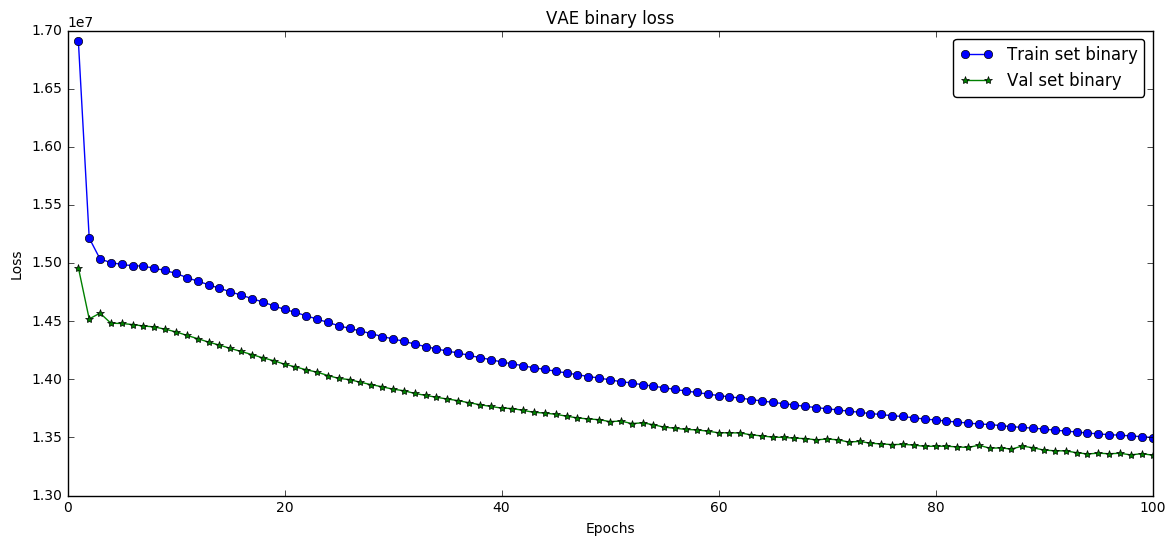

Valor anterior de precision:  0.35
Precision con epoch= 100 0.37125228959799317


In [126]:
##aumentar los epochs mejora?? --> si!
history_dict2 = hist2.history
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs_l = range(1, len(loss_values2) + 1)

plt.figure(figsize=(14,6))
plt.plot(epochs_l, loss_values2, 'bo-', label = "Train set binary")
plt.plot(epochs_l, val_loss_values2, 'g*-', label = "Val set binary")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE binary loss")
plt.show()

print("Valor anterior de precision: ",0.35)
print("Precision con epoch= 100",precision)

## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [22]:
def evaluate_hashing(encoder,train,test,labels_trainn,labels_testt,traditional=True,tipo="topK"):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    encode_train = encoder.predict(train)
    encode_test = encoder.predict(test)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        
        train_hash = median.transform(encode_train)
        test_hash = median.transform(encode_test)
    else: #para Binary VAE
        probas_train = expit(encode_train)
        probas_test = expit(encode_test)
        
        train_hash = (probas_train > 0.5)*1
        test_hash = (probas_test > 0.5)*1

    test_similares_train =  get_similar(test_hash,train_hash,tipo="topK",K=100)
    return measure_metrics(labels,test_similares_train,labels_query=labels_testt,labels_source=labels_trainn)

#to save results
results_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for topk
BITS = 32

In [68]:
X_total_input = np.concatenate((X_train_input,X_val_input),axis=0)
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=BITS,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=BITS,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_115 (Bat (None, 500)               2000      
_________________________________________________________________
dense_186 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_116 (Bat (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_187 (Dense)            (None, 1000

In [69]:
dataset = dat_n.lower()

p_t,r_t = evaluate_hashing(encoder_Tvae,X_total_input,X_test_input,labels_total,labels_test,traditional=True,tipo="topK")
results_dat[dataset]["p"].append(p_t)
results_dat[dataset]["r"].append(r_t)
print("Realizado sobre dataset ",dataset,"con precision y recall para VAE",p_t,r_t)

p_b,r_b = evaluate_hashing(encoder_Bvae,X_total_input,X_test_input,labels_total,labels_test,traditional=False,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
print("Realizado sobre dataset ",dataset,"con precision y recall para B-VAE",p_b,r_b)

Realizado sobre dataset  snippets con precision y recall para VAE 0.30699999999999944 0.0256122465954154
Realizado sobre dataset  snippets con precision y recall para B-VAE 0.37737280701754317 0.03216375408097676


In [71]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["20News"] = results_dat["20news"]["p"]
t["Reuters"] = results_dat["reuters"]["p"]
t["Snippets"] = results_dat["snippets"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["20News"] = results_dat["20news"]["r"]
t["Reuters"] = results_dat["reuters"]["r"]
t["Snippets"] = results_dat["snippets"]["r"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         20News            Reuters             Snippets     
----------- ------------------ ------------------ -------------------
Tradicional 0.3431515812431836 0.5553671147880049 0.30699999999999944
    Binario 0.5024236641221376 0.7487176835573954 0.37737280701754317


Resultados de Recall en pruebas
   Modelo          20News             Reuters             Snippets     
----------- ------------------- ------------------- -------------------
Tradicional 0.04606468575895281 0.04022549955669577  0.0256122465954154
    Binario 0.06736207638468589 0.05967716214082507 0.03216375408097676


La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [25]:
traditional_dat_BS = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for ball radius
binary_dat_BS = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for ball radius

In [70]:
%%time
dataset = dat_n.lower()
ball_radius = np.arange(0,BITS) #ball of radius graphic

binary_p = []
binary_r = []
encode_total = encoder_Bvae.predict(X_total_input)
encode_test = encoder_Bvae.predict(X_test_input)
probas_total= expit(encode_total)
probas_test= expit(encode_test)
total_hash_b = (probas_total > 0.5)*1
test_hash_b = (probas_test > 0.5)*1
    
traditional_p = []
traditional_r = []
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
median= MedianHashing()
median.fit(encode_total)
total_hash_t = median.transform(encode_total)
test_hash_t = median.transform(encode_test)


for ball_r in ball_radius:
    test_similares_train =  get_similar(test_hash_b,total_hash_b,tipo='ball',ball=ball_r) 
    p_b,r_b  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    binary_dat_BS[dataset]["p"].append(p_b)
    binary_dat_BS[dataset]["r"].append(r_b)
    
    test_similares_train =  get_similar(test_hash_t,total_hash_t,tipo='ball',ball=ball_r) 
    p_t,r_t  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    traditional_dat_BS[dataset]["p"].append(p_t)
    traditional_dat_BS[dataset]["r"].append(r_t)

print("Termino")

Termino
CPU times: user 1min 44s, sys: 759 ms, total: 1min 45s
Wall time: 1min 44s


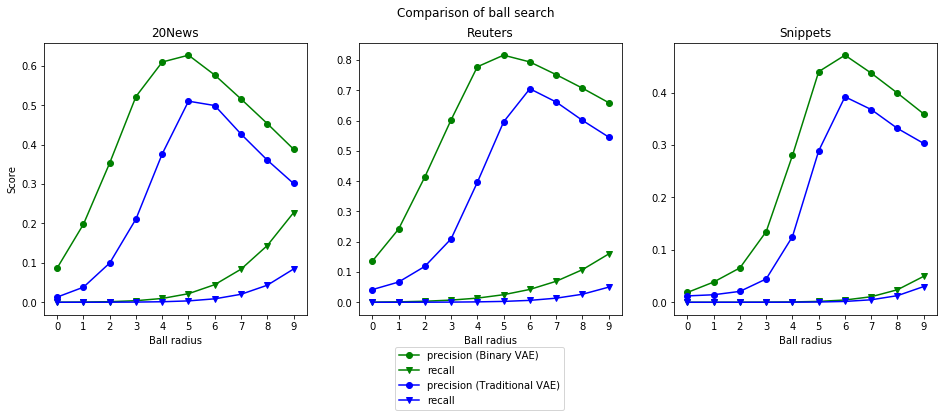

In [84]:
choosed_data = ["20News", "Reuters", "Snippets"]
f, axx = plt.subplots(1, len(choosed_data), figsize=(16,5), sharey=False)

b_aux = 10
for z in range(len(choosed_data)):
    dat = choosed_data[z].lower()

    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["p"][:b_aux],'go-',label="precision (Binary VAE)")
    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["r"][:b_aux],'gv-', label='recall' ) 
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["p"][:b_aux],'bo-',label="precision (Traditional VAE)")
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["r"][:b_aux],'bv-', label='recall' ) 
    axx[z].set_title(choosed_data[z])
    axx[z].set_xticks(ball_radius)
    axx[z].set_xlabel("Ball radius")
    axx[z].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    #axx[z].set_ylim(-0.05)
    
    if z == 0:
        axx[z].set_ylabel("Score")
        axx[z].legend(bbox_to_anchor=(2, -0.1))
        
f.suptitle("Comparison of ball search")
plt.show()

Se puede ver que la experimentación con el radio de búsqueda refleja que mejores resultados se pueden alcanzar, por ejemplo en Reuters llegar a 0.8 de *precision* y en 20 News a 0.5. Al aumentar el radio de búsqueda ambas métricas aumentan hasta un cierto punto (3-5) en donde se comienza a observar el típico *trade-off* entre *precision* y *recall*, a un mayor *precision* un menor *recall*.

### Analysis
---
A continuación se realiza el análisis final del modelo binario de *VAE*, gracias a que modela las probabilidades de los códigos binarios directamente es posible interpretarlos a través de las palabras más probables que representan cada *bit* en cada dataset.

1. "Encender" solo un *bit* como *input* al *decoder*/*generator*
2. Realizar un *forward pass* para obtener la distribución de probabilidad de las palabras
3. Obtener las top $M$ palabras más probables.

In [55]:
def get_topk_probably_words(probabilities,K):
    order_vocabulary =  np.argsort(probabilities) 
    tokens_probables = order_vocabulary[:K]  #token mas probables
    return list(map(lambda x:idx2token[x] ,tokens_probables))

def calculate_hash(data,model):
    encode_data = model.predict(data) #logits
    #para Binary VAE
    probas_data = expit(encode_data)
    data_hash = (probas_data > 0.5)*1
    return data_hash

def plot_cells_distribution(Nb,train_hash,test_hash=[]):
    print("Cantidad de memorias en tabla hash: ",2**Nb)

    valores_unicos, count_hash =  hash_analysis(train_hash)
    print("Entrenamiento----")
    print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
    plt.figure(figsize=(14,4))
    plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
    plt.title("Cantidad de datos por celda/memoria en tabla hash")
    plt.show()
    print("Cantidad de memorias ocupadas: ",len(valores_unicos))
    if len(test_hash) != 0:
        valores_unicos, count_hash =  hash_analysis(test_hash)
        print("Pruebas-----")
        print("Cantidad de datos a llenar la tabla hash: ",test_hash.shape[0])
        plt.figure(figsize=(14,4))
        plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
        plt.title("Cantidad de datos por celda/memoria en tabla hash")
        plt.show()
        print("Cantidad de memorias ocupadas: ",len(valores_unicos))
        
from utils import  compare_cells_plot

In [121]:
Nb = encoder_Bvae.output_shape[1]

train_hash = calculate_hash(X_total_input,encoder_Bvae)
test_hash = calculate_hash(X_test_input,encoder_Bvae)

In [ ]:
from sklearn.manifold import TSNE
n = 3000 #data to train
model = TSNE(n_components=2, metric='hamming', init= "random") #init could be pca, hamming
train_plot =  model.fit_transform(train_hash[:n])

In [ ]:
print("20 Newsgroup")
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])]) #labels??
plt.figure(figsize=(10,7))
plt.scatter(train_plot[:,0],train_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) 
plt.show()

In [ ]:
print("Reuters")


In [ ]:
print("Snippets")



Cantidad de memorias en tabla hash:  4294967296
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  8485


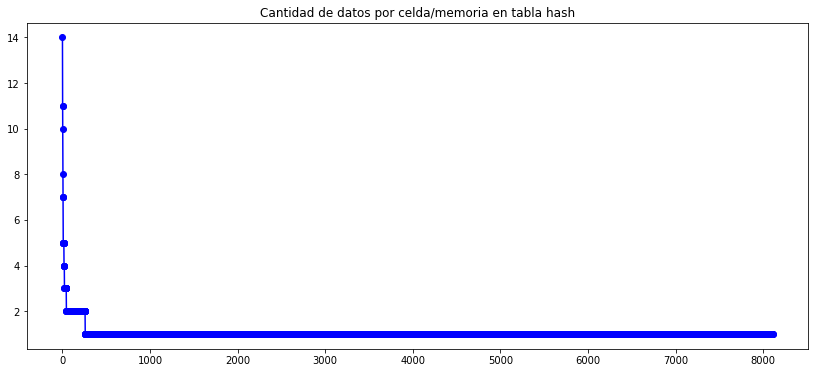

Cantidad de memorias ocupadas:  8108
Validación-----
Cantidad de datos a llenar la tabla hash:  2829


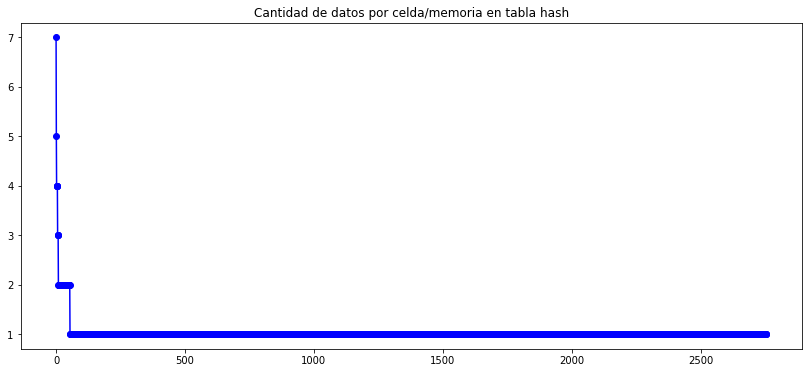

Cantidad de memorias ocupadas:  2756


In [20]:
print("Cantidad de memorias en tabla hash: ",2**Nb)

valores_unicos, count_hash =  hash_analysis(train_hash)
print("Entrenamiento----")
print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

valores_unicos, count_hash =  hash_analysis(val_hash)
print("Validación-----")
print("Cantidad de datos a llenar la tabla hash: ",val_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

Se puede ver que se ocupan varias celdas de memorias gracias a la restricción de las variables latentes en el VAE, donde en la mayoría de los casos se asigna una única dirección de memoria para un objeto, obteniendo una tabla *hashing* distribuidamente poblada.  

> Y si se varía el número de bits?

Cantidad de memorias en tabla hash:  256
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  10060
Cantidad de memorias ocupadas hash1:  256
Cantidad de memorias ocupadas hash2:  252


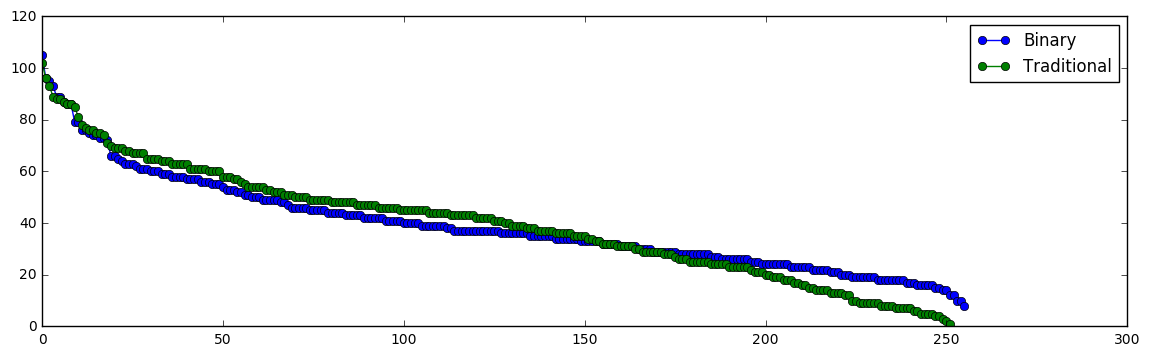

Pruebas-----
Cantidad de datos a llenar la tabla hash:  2280
Cantidad de memorias ocupadas hash1:  252
Cantidad de memorias ocupadas hash2:  234


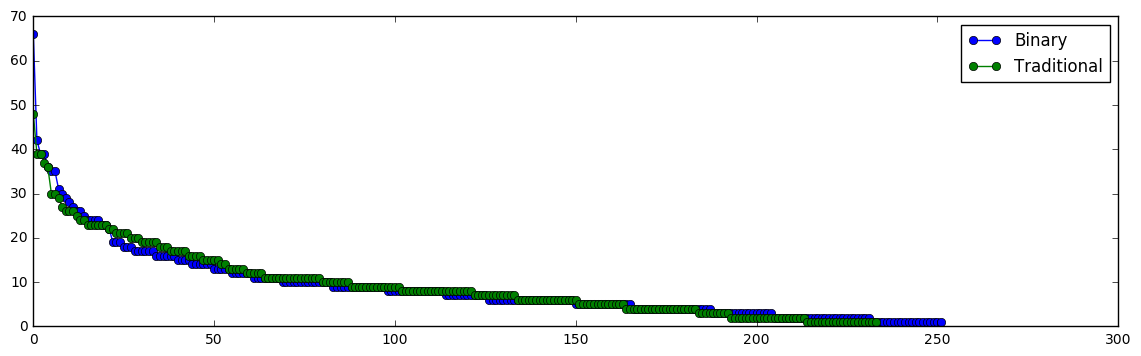

In [91]:
#plot together--8 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

Cantidad de memorias en tabla hash:  16
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  10060
Cantidad de memorias ocupadas hash1:  16
Cantidad de memorias ocupadas hash2:  16


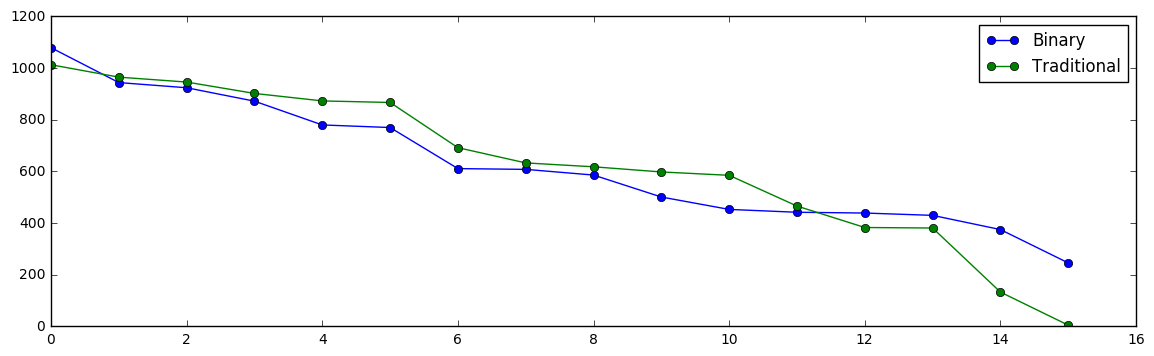

Pruebas-----
Cantidad de datos a llenar la tabla hash:  2280
Cantidad de memorias ocupadas hash1:  16
Cantidad de memorias ocupadas hash2:  16


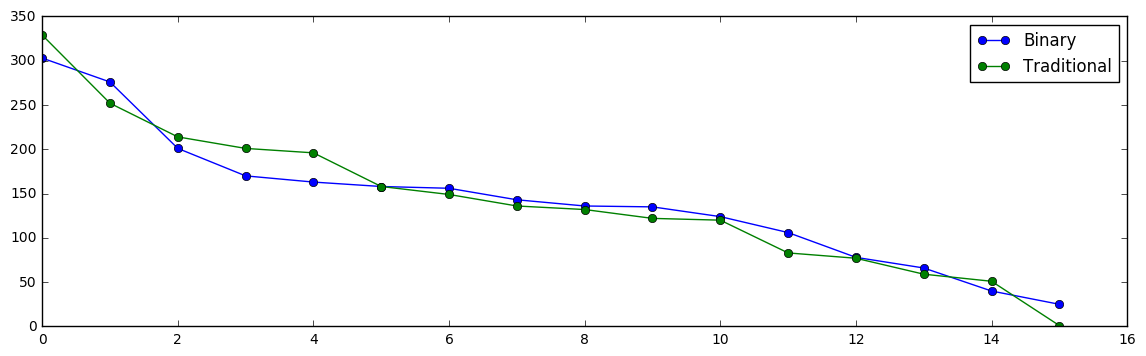

In [94]:
#plot together--- 4 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

In [19]:
#Normal AE
Nb = 8
pre_encoder = define_pre_encoder(X_total_input.shape[1], layers=2,units=500,BN=True)
decoder = define_generator(Nb,X_total_input.shape[1],layers=2,units=500,BN=True) #2 layers?
## Encoder
x = Input(shape=(X_total_input.shape[1],))
hidden = pre_encoder(x)
code = Dense(Nb,activation='sigmoid')(hidden) #sigmoid?
encoder = Model(x, code) # build a model to project inputs on the latent space
## Decoder
output = decoder(code)
normal_AE = Model(x, output)
normal_AE.summary()

normal_AE.compile(optimizer='adam',loss='categorical_crossentropy')
normal_AE.fit(X_total_input,X_total,epochs=50,batch_size=100,verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
pre-encoder (Sequential)     (None, 500)               5255000   
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 4008      
_________________________________________________________________
generator/decoder (Sequentia (None, 10000)             5269000   
Total params: 10,528,008
Trainable params: 10,524,008
Non-trainable params: 4,000
_________________________________________________________________


Cantidad de memorias en tabla hash:  256
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  11314


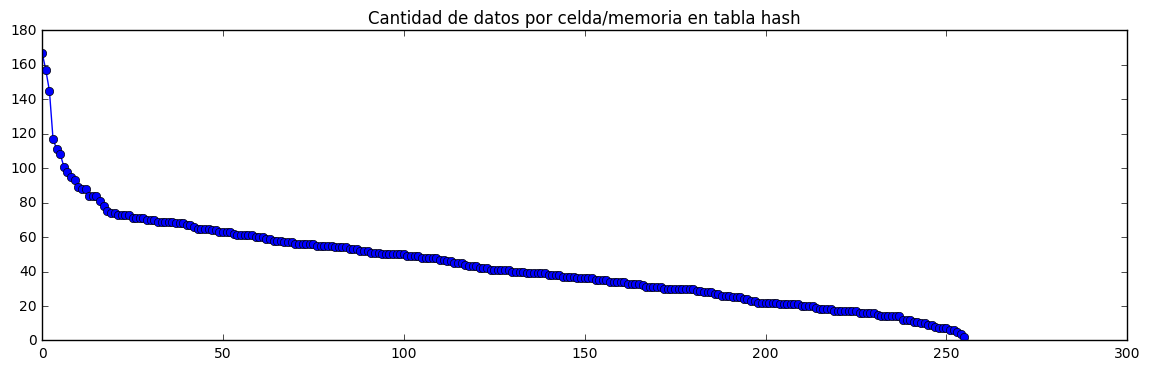

Cantidad de memorias ocupadas:  256
Pruebas-----
Cantidad de datos a llenar la tabla hash:  7532


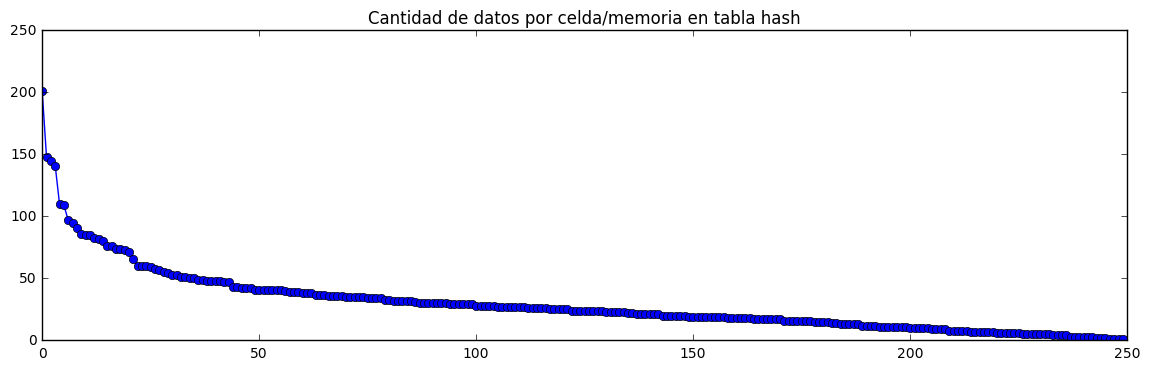

Cantidad de memorias ocupadas:  250


In [20]:
#Normal AE -- binary
probas_total = encoder.predict(X_total_input)
probas_test = encoder.predict(X_test_input)
train_hash = (probas_total > 0.5)*1
test_hash = (probas_test > 0.5)*1
plot_cells_distribution(Nb,train_hash,test_hash)

Los resultados se mantienen al variar los datasets, así que se muestra unicamente uno. El autoencoder clásico, muestra comportamiento similar, exceptuando quizás por una leve falta de generalización en el conjunto objetivo (de pruebas), ésto quiere decir que la hipótesis de que la distribución repartida de las celdas era debido al autoencoder variacional **estaba erronea**, ya que el autoencoder clásico lo logra. Respecto a quién logra una mejor distribución uniforme de las casillas depende, ya que por ejemplo en reuters lo logra el VAE tradicional, mientras que en snippets lo logra el VAE binario.  
**Resultado esperado**: se mantiene la idea de que se distribuyen los datos a través de todas las casillas disponibles, mientras que si se tiene las casillas suficientes va haber un dato por cada casilla.

In [54]:
#iterar sobre el resto de los bits y ver sus palabras mas frecuentes
def show_probable_words(topKwords,samplebits):
    probable_words = []
    for i in range(Nb):
        b = np.zeros((1,Nb))
        b[0,i] = 1 #solo un bit con uno

        reconstruct_data = generator_Bvae.predict(b)
        probable_words.append(get_topk_probably_words(reconstruct_data[0],K=topKwords))
    
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False)
    t = Table()
    for b in bits:
        t["bit "+ str(b)] = probable_words[b]
    return t

A continuación se muestrean las 12 palabras más frecuentes de 8 *bits*  aleatorios distintos en el modelo.

In [26]:
print("20 Newsgroup")
show_probable_words(12,8)

20 Newsgroup


bit 22,bit 13,bit 5,bit 14,bit 29,bit 9,bit 30,bit 18
str12,str7,str12,str12,str13,str13,str13,str13
mimsy,megatek,rigorous,invitation,rigorous,complexity,heterosexual,newman
hopper,lbl,complexity,inconsistent,governing,heterosexual,invitation,likelihood
newman,newman,hubble,ehrlich,p00261,likelihood,pythagorean,slac
complexity,acme,mimsy,lbl,ebay,inconsistent,preservation,bernard
heterosexual,grief,likelihood,asia,eager,lbl,dani,rigorous
slac,ccc,inconsistent,kou,bernard,skeptic,harassment,sax
lbl,amdahl,finite,newman,inaccurate,presidential,homosexuality,dsi
dani,fuer,sl2,guidance,misunderstand,prohibits,lbl,introductory
hubble,rusnews,refutation,jhuapl,dishonest,homosexuality,asia,ranting


In [112]:
print("20 Newsgroup--collocations")
show_probable_words(12,8)

20 Newsgroup--collocations


bit 8,bit 4,bit 26,bit 5,bit 15,bit 27,bit 3,bit 7
str30,str24,str30,str27,str30,str30,str30,str30
communication greenbelt usa,article pitt,communication greenbelt usa,berkeley line,distribution sci line,organization express access,posting host access,organization express access
california berkeley line,organization sgi,communication greenbelt,ibm austin,article blue,posting host access,host access digex,express access
communication greenbelt,berkeley line,online communication greenbelt,organization express access,drive scsi,host access digex,communication greenbelt usa,organization express
online communication greenbelt,ibm austin,organization express access,california berkeley line,chapel hill,distribution sci line,organization express access,posting host access
berkeley line,gordon bank writes,organization express,posting host access,berkeley line,express access,online communication greenbelt,host access digex
mild,bbn,express access,express access,communication greenbelt,organization express,express access,express access online
distribution sci line,university western,express access online,host access digex,communication greenbelt usa,communication greenbelt usa,organization express,access online
frontier,california berkeley line,chapel hill,organization express,online communication greenbelt,express access online,communication greenbelt,access online communication
ulysses,wpd sgi,access online,express access online,california berkeley line,communication greenbelt,express access online,communication greenbelt usa


En el dataset de *20 Newsgroup* se puede ver por ejemplo que el *bit* 9 contiene palabras como *heterosexual*, *presidential*, *prohibits*, *eternity* y *homosexuality*, pudiendo ser asociados a textos que contengan una discusión política de la sexualidad o palabras con connotación negativa. El *bit* 13 podría estar asociado a empresas u organizaciones/entidades conocidas, al contener *newman*, *ebay*, *hubble* y *acme*.

In [46]:
print("Reuters")
show_probable_words(12,8)

Reuters


bit 9,bit 31,bit 21,bit 7,bit 14,bit 29,bit 5,bit 17
str11,str14,str12,str12,str12,str10,str14,str11
danger,device,eed,printing,murray,toronto,responsibility,printing
object,recognize,consummated,ica,hindered,receivable,weakening,analyze
consummated,responsibility,analyze,elmd,baby,catalyst,recognize,device
relate,analyze,recognize,projecting,accurate,murray,analyze,dallas
hostile,printing,moines,analyze,proceeding,stretch,edition,catalyst
weakening,undoubtedly,cancellation,baby,justify,printing,colo,exploring
cellular,describing,severance,kpk,master,analyze,sierra,proof
printing,existence,colo,device,uneconomic,projecting,eighth,elmd
uneconomic,projecting,defensive,undoubtedly,jacksonville,edmonton,mature,object


In [103]:
print("Reuters--collocations")
show_probable_words(12,8)

Reuters--collocations


bit 10,bit 17,bit 30,bit 0,bit 2,bit 20,bit 23,bit 21
str19,str22,str19,str19,str19,str19,str19,str19
company share,dlrs unit,fit,corp said board,corp said board,company share,corp said board,said pay
corp said board,second largest,second largest,receive mln dlrs,dlrs unit,receive mln dlrs,dlrs unit,said planned
manufacture,said pay,said pay,sustained,said pay,expected close,said pay,participate
dlrs unit,dlrs worth,company share,dlrs unit,form new,said board approved,receive mln dlrs,shareholder company
sale billion dlrs,receive mln dlrs,financially,expected close,said board approved,dlrs unit,salomon brother,stake company
said pay,said make,stake company,fit,said considering,fit,said board approved,receive mln dlrs
recommend,said considering,advise,shareholder company,dividend share,cheap,company share,company share
shareholder company,told reuters interview,sale billion dlrs,close april,expected close,said pay,sale billion dlrs,corp said board
announce,mln dlrs worth,expected result,payment said,rise dollar,corp said board,mob,holder record


En el dataset de *Reuters* el *bit* 31 alberga conceptos asociados a computadores, como lo son *device*, *analyze*, *printing*, *projecting*, *exploring* y *object*. 

In [61]:
print("Snippets")
show_probable_words(12,8)

Snippets


bit 29,bit 25,bit 0,bit 30,bit 15,bit 24,bit 19,bit 4
str12,str14,str12,str12,str12,str13,str12,str12
interaction,interaction,biogeography,emc,chamber,managing,gymnastics,biogeography
biogeography,biogeography,interactive,investor,agency,biogeography,chamber,emc
gymnastics,composer,composer,biogeography,patient,emc,biogeography,gymnastics
requirement,radiology,gymnastics,requirement,biogeography,ecology,cam,interaction
specializes,gymnastics,chamber,unl,emc,visualization,healthcare,beginner
logo,patient,campus,chamber,cdc,lighting,focusing,consisting
consisting,seattle,ballet,ecology,specializes,cable,cdc,newsday
butler,creative,lesson,interaction,composer,credible,flat,unl
emc,ballet,requirement,beginner,drama,interaction,interactive,historic


In [122]:
print("Snippets--collocations")
show_probable_words(12,8)

Snippets--collocations


bit 17,bit 30,bit 9,bit 4,bit 15,bit 7,bit 18,bit 0
str20,str9,str20,str10,str20,str20,str18,str20
indexed,flight,flight,abroad,nato,indexed,firm,unlimited
treaty,real,search web,sql,indexed,jesus,indexed,firm
firm,steam,treaty,real,search web,sql,unlimited,web browser
accessibility,editing,web search,indexed,web search,columbia edu,web search,research development
scholarly,firm,nato,issued,research development,manhattan,ticket information,academic research
nato,chronicle,research development,applicant,research research,real,search web,flight
counselor,scholarly,firm,firm,treaty,monthly magazine,btinternet,applicant
link resource,issued,editing,unlimited,soldier,research development,wideless,conversion
resource english,sql,sql,web search,tree,flight,manhattan,treaty


En el dataset de *Snippets* se puede ver por ejemplo que el *bit* 30 almacena conceptos como *ecology*, *geographical* y *wildlife*, pudiendo ser asociado a textos que hablen de la temática de fauna. El bit *25* contiene términos asociados a salud o deporte, como *radiology*, *gymnastics*, *patient* y *strength*.

## Trabajo Futuro
Experimentar con redes recurrentes como el modelo de *encoder* y otra para el modelo de *decoder*/*generator*.

### Referencias
---
[1] Salakhutdinov, R., & Hinton, G. (2009). *Semantic hashing*. International Journal of Approximate Reasoning, 50(7), 969-978.  
[2] Chaidaroon, S., & Fang, Y. (2017, August). *Variational deep semantic hashing for text documents*. In Proceedings of the 40th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 75-84). ACM.  
[3] Chaidaroon, S., Ebesu, T., & Fang, Y. (2018). *Deep Semantic Text Hashing with Weak Supervision*. SIGIR.  
[4] Maddison, C. J., Mnih, A., & Teh, Y. W. (2016). The concrete distribution: A continuous relaxation of discrete random variables. arXiv preprint arXiv:1611.00712.  
[5] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.